In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
import time
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

import bda_utils

In [2]:
bda_utils.setup_seed(10)

# 1. BDA Part
## 1.a. Define BDA methodology

In [3]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [4]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
#         ipdb.set_trace()
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X_mean = np.linalg.norm(X, axis=0)  # why it's axis=0? the average of features
        X_mean[X_mean==0] = 1
        X /= X_mean
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = np.unique(Ys)
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            print('\tStarting iter %i'%t)
            N = 0
            M0 = e * e.T * len(C)
#             ipdb.set_trace()
            if Y_tar_pseudo is not None:
                for i in range(len(C)):
                    e = np.zeros((n, 1))
                    
                    Ns = len(Ys[np.where(Ys == C[i])])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == C[i])])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
#                         mu = 1
                    else:
                        alpha = 1
                    
                    tt = Ys == C[i]
                    e[np.where(tt == True)] = 1 / Ns
#                     ipdb.set_trace()
                    yy = Y_tar_pseudo == C[i]
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    try:
                        e[tuple(inds)] = -alpha / Nt
                        e[np.isinf(e)] = 0
                    except:
                        e[tuple(inds)] = 0  # ？
                    N = N + np.dot(e, e.T)

#             ipdb.set_trace()
            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
#             ipdb.set_trace()
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
#             ipdb.set_trace()
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z_mean = np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Z_mean[Z_mean==0] = 1
            Z /= Z_mean
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            
            global device
            model = sklearn.svm.SVC(kernel='linear').fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = model.predict(Xt_new)
#             ipdb.set_trace()
            acc = sklearn.metrics.mean_squared_error(Y_tar_pseudo, Yt)  # Yt is already in classes
            print(acc)


        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

## 1.b. Load Data

In [5]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:,8:9]
Xt = Xt[:,8:9]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

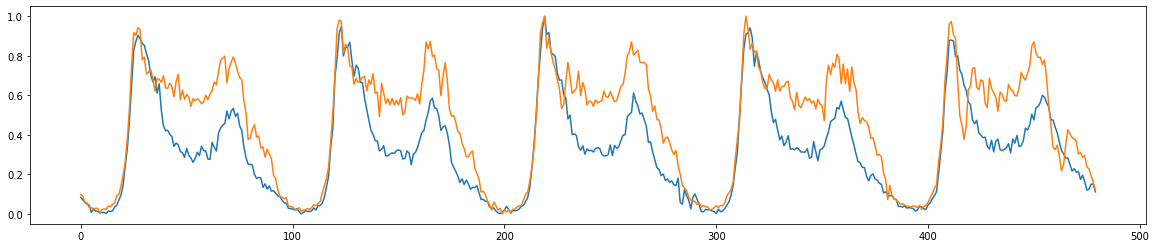

In [6]:
for i in range(Xs.shape[1]):
    plt.figure(figsize=[20,4])
    plt.plot(Xs[:, i])
    plt.plot(Xt[:, i])

## 1.d. Hyperparameters

In [7]:
label_seq_len = 7
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 2
MU = 0.7
bda_dim = label_seq_len-4
kernel_type = 'linear'

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb,
    'MU': MU,
    'bda_dim':bda_dim,
    'kernel_type':kernel_type}

hyper = pd.DataFrame(hyper, index=['Values'])

In [8]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb,MU,bda_dim,kernel_type
Values,1,1,7,12,4,12,1,2,0.7,3,linear


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [9]:
Xs = Xs[:96, :]

In [10]:
# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)
Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(78, 12, 1)
(78, 1, 1)
(462, 12, 1)
(462, 1, 1)


In [11]:
t_s = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):
    print('Starting det %i'%i)
    bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=MU, gamma=1, T=2)  # T is iteration time
    Xs_new, Xt_new, A = bda.fit(
        Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
    )  # input shape: ns, n_feature | ns, n_label_feature
    
    # normalize
    Xs_new, Xs_new_min, Xs_new_max = bda_utils.normalize2D(Xs_new)
    Xt_new, Xt_new_min, Xt_new_max = bda_utils.normalize2D(Xt_new)
    
    print(Xs_new.shape)
    print(Xt_new.shape)

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(96*day_train_t):, :]
    Xt_train = Xt_new.copy()[:int(96*day_train_t), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(96*day_train_t):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(96*day_train_t), :]
    

print('Time spent:%.5f'%(time.time()-t_s))

Starting det 0
	Starting iter 0
1008.547619047619
	Starting iter 1
778.0194805194806
(78, 8)
(462, 8)
Time spent:0.72056


In [12]:
print(Xs_train.shape)
print(Ys_train.shape)
print(Xt_valid.shape)
print(Xt_train.shape)
print(Yt_valid.shape)
print(Yt_train.shape)

(78, 8)
(78, 1)
(366, 8)
(96, 8)
(366, 1)
(96, 1)


In [13]:
train_x = np.vstack([Xs_train, Xt_train])
train_y = np.vstack([Ys_train, Yt_train])

# 2. Regression Part

In [14]:
import xgboost as xgb

In [15]:
regr = xgb.XGBRegressor(tree_method="gpu_hist")  # XGBoost
regr.fit(train_x, train_y.flatten())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

# 3. Evaluation

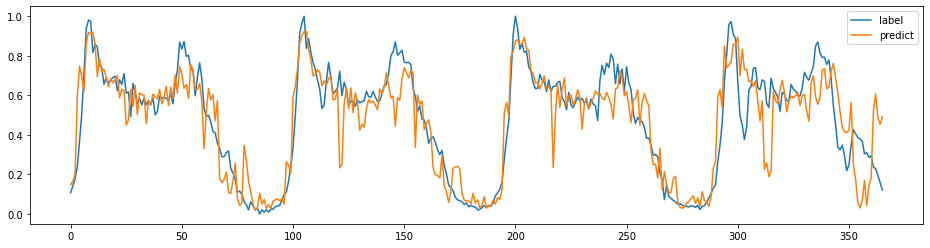

In [16]:
g_t = Yt_valid.flatten()
pred = regr.predict(Xt_valid)

plt.figure(figsize=[16,4])
plt.plot(g_t, label='label')
plt.plot(pred, label='predict')
plt.legend()

In [17]:
print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.mape_loss_func(pred, g_t, 0))
print(bda_utils.smape_loss_func(pred, g_t, 0))
print(bda_utils.mae_loss_func(pred, g_t, 0))

0.13687259701033364
0.4029288499663805
0.3073163678765882
0.09784884561213247


C:\Users\10169\Documents\Github\BDA_traffic\bda_utils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))


Text(0, 0.5, 'Flow [veh/hr]')

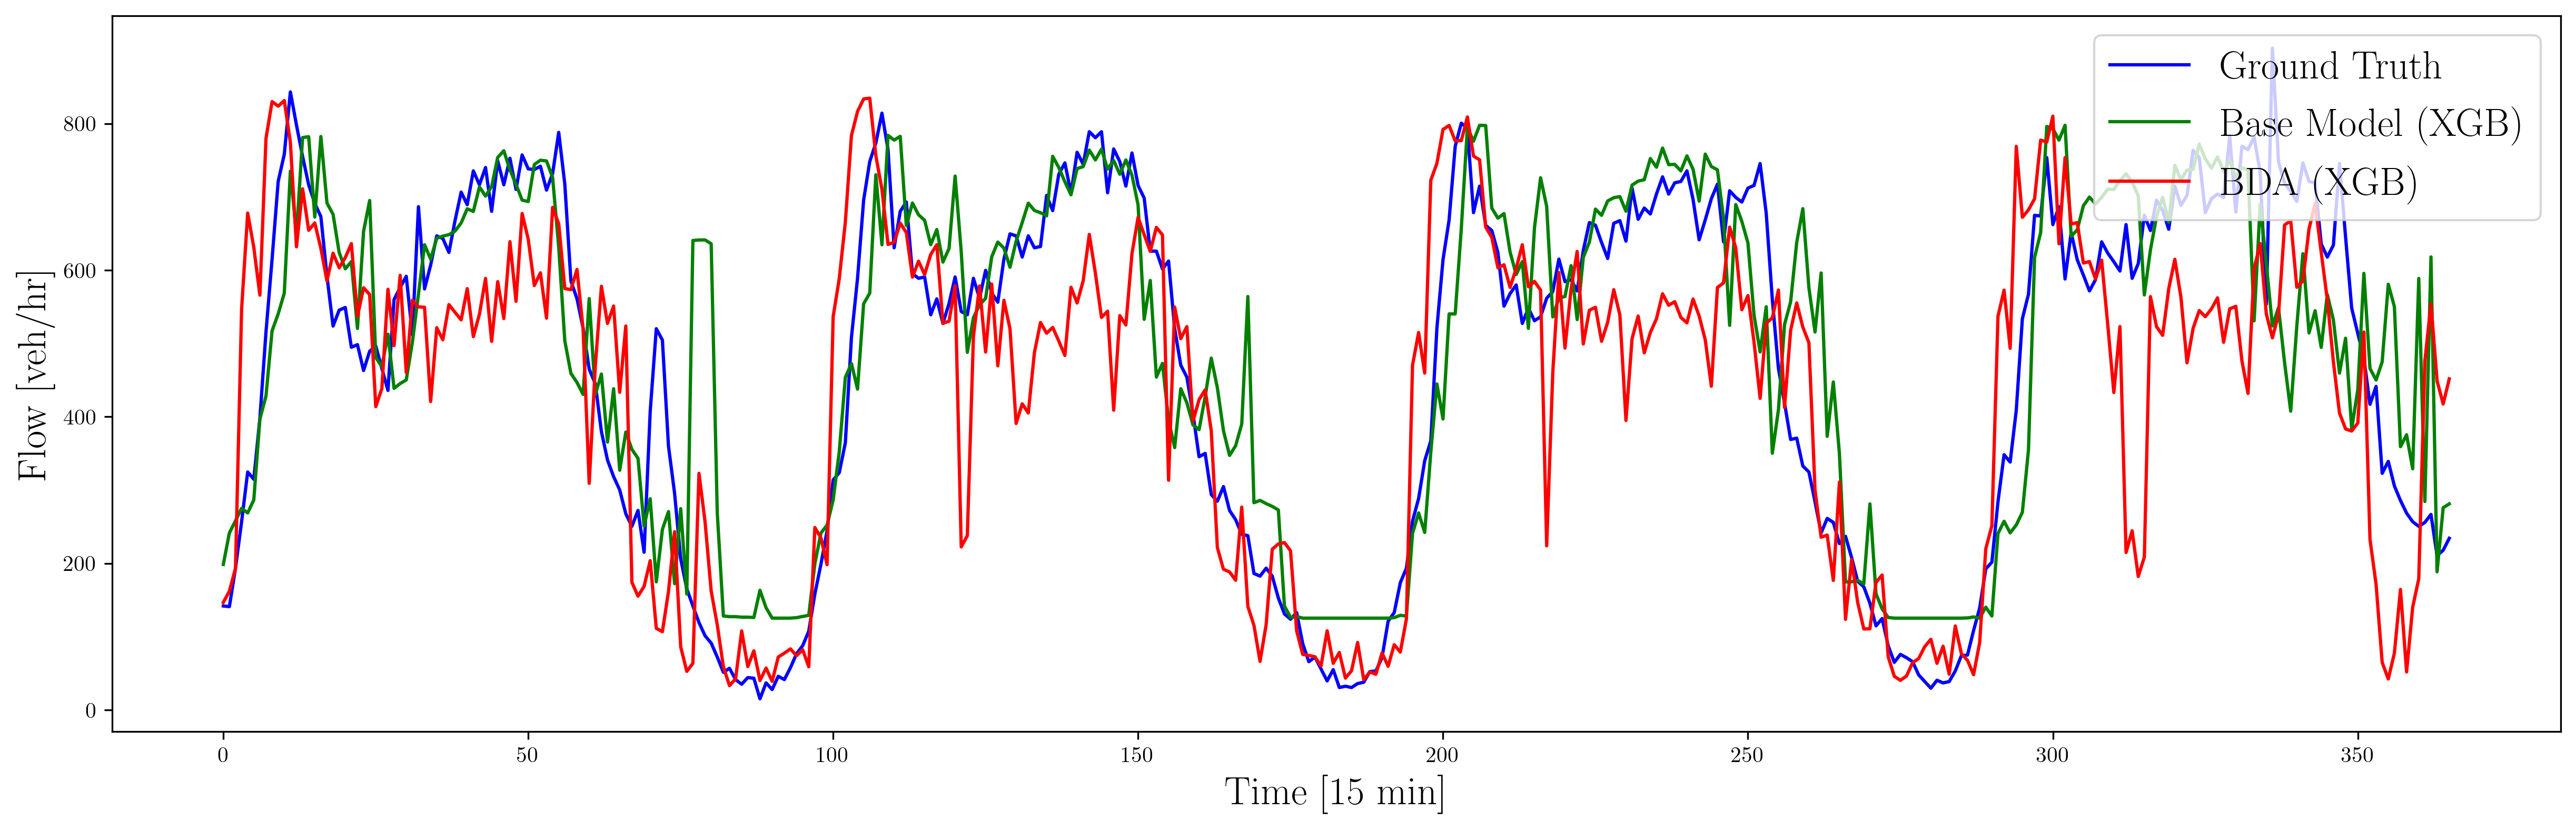

In [35]:
pred_base = pd.read_csv('./runs_base/base_data_plot/pred_base_XGB.csv', header=None)
g_t_base = pd.read_csv('./runs_base/base_data_plot/g_t_base_XGB.csv', header=None)

plt.rc('text', usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=[20, 6], dpi=300)
diff = g_t_base.shape[0]-g_t.shape[0]
plt.plot(range(g_t.shape[0]), g_t_base[diff:]*(903-15)+15, 'b', label='Ground Truth')
plt.plot(range(g_t.shape[0]), pred_base[diff:]*(903-15)+15, 'g', label='Base Model (XGB)')
# plt.figure()
# plt.plot(range(371), g_t_bda)
plt.plot(range(g_t.shape[0]), pred*(903-15)+15, 'r', label='BDA (XGB)')
plt.legend(loc=1, fontsize=18)
plt.xlabel('Time [15 min]', fontsize=18)
plt.ylabel('Flow [veh/hr]', fontsize=18)